<a href="https://colab.research.google.com/github/phps-28/Data-Science-PGEBM/blob/master/Mestrado/Projeto/T_1/T_1_15_14_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Controle de Versões

##### Definição da codificação
 Ex: (1.0.0.0)
- 1: Tipo de modelo de rede neural
- 0: Mudanças lógica, código ou estratégia
- 0: Mudança de parâmetros
- 0: Mudança de base de dados
<br>
<br>

Releitura do modelo T.1.15.14.1. Tal está na pasta de modelo treinados - 11/11/24

# Importação das bibliotecas

In [1]:
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import numpy as np
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow import keras
from tensorflow.keras import layers

## Subindo o arquivo zipado com as imagens

In [17]:
!unzip -q Base_2_Classes_B_R.zip
!ls

Base_2_Classes_B_R  Base_2_Classes_B_R.zip  sample_data


In [18]:
!ls Base_2_Classes_B_R

00R  01B


In [19]:
import os

# Todas as categorias
num_skipped = 0
for folder_name in ("00R", "01B"): # descrevendo as pastas presentes dentro do arquivo main "Base"
    folder_path = os.path.join("Base_2_Classes_B_R", folder_name) # juntando o caminho de cada uma das pastas com o caminho da main pasta
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname) # estabelecendo o caminho completo de cada imagem dentro da pasta main e subpastas
        try:
            fobj = open(fpath, "rb") # lendo e abrindo cada uma das imagens
            is_pfif = tf.compat.as_bytes("PFIF") in fobj.peek(10) # verificando a extensão correta das imagens '.png'
            # (T.1.0.3.1)
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10) # verificando a extensão correta das imagens '.jpg'
            #
        finally:
            fobj.close()

print("Deletadas %d imagens" % num_skipped)

Deletadas 0 imagens


# Gerando os Datasets de treino, teste e validação randomicamente

In [20]:
import os
import random
from shutil import copyfile

# Diretório original das imagens
original_dataset_dir = '/content/Base_2_Classes_B_R'

# Diretório de destino para os conjuntos de treinamento, teste e validação
base_dir = '/content'
os.makedirs(base_dir, exist_ok=True)

train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)

test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

val_dir = os.path.join(base_dir, 'validation')
os.makedirs(val_dir, exist_ok=True)

# Lista de classes (subdiretórios) no diretório original
classes = os.listdir(original_dataset_dir)

# Defina as proporções de imagens para treinamento (80%), teste (10%) e validação (10%)
train_split = 0.8
test_split = 0.1

# Itera sobre cada classe para criar os conjuntos de treinamento, teste e validação
for class_name in classes:
    class_dir = os.path.join(original_dataset_dir, class_name)

    # Lista de todas as imagens na classe
    images = os.listdir(class_dir)

    # Embaralha a lista de imagens para dividir aleatoriamente
    random.shuffle(images)

    # Calcula os índices para dividir entre treinamento, teste e validação
    train_index = int(len(images) * train_split)
    test_index = train_index + int(len(images) * test_split)

    # Lista de imagens para treinamento, teste e validação
    train_images = images[:train_index]
    test_images = images[train_index:test_index]
    val_images = images[test_index:]

    # Cria os subdiretórios de treinamento, teste e validação para a classe
    train_class_dir = os.path.join(train_dir, class_name)
    os.makedirs(train_class_dir, exist_ok=True)

    test_class_dir = os.path.join(test_dir, class_name)
    os.makedirs(test_class_dir, exist_ok=True)

    val_class_dir = os.path.join(val_dir, class_name)
    os.makedirs(val_class_dir, exist_ok=True)

    # Copia as imagens para os diretórios de treinamento, teste e validação
    for img in train_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(train_class_dir, img)
        copyfile(src, dst)

    for img in test_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(test_class_dir, img)
        copyfile(src, dst)

    for img in val_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(val_class_dir, img)
        copyfile(src, dst)

print('Feito!')


Feito!


# Dataset Treino + Data Augmentation

In [21]:
# (T.1.15.14.1)
gerador_treinamento = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
                                        #Data Augmentation
                                        zoom_range=0.2,
                                        rotation_range=20,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.2,
                                        horizontal_flip=True,
                                        fill_mode='nearest')

dataset_treinamento = gerador_treinamento.flow_from_directory('/content/train',
                                                              target_size=(224,224),
                                                              color_mode = 'rgb',
                                                              batch_size=16,
                                                              class_mode='categorical',
                                                              shuffle = True) # as imagens do dataset serão embaralhadas antes de cada época



Found 570 images belonging to 2 classes.


In [22]:
dataset_treinamento

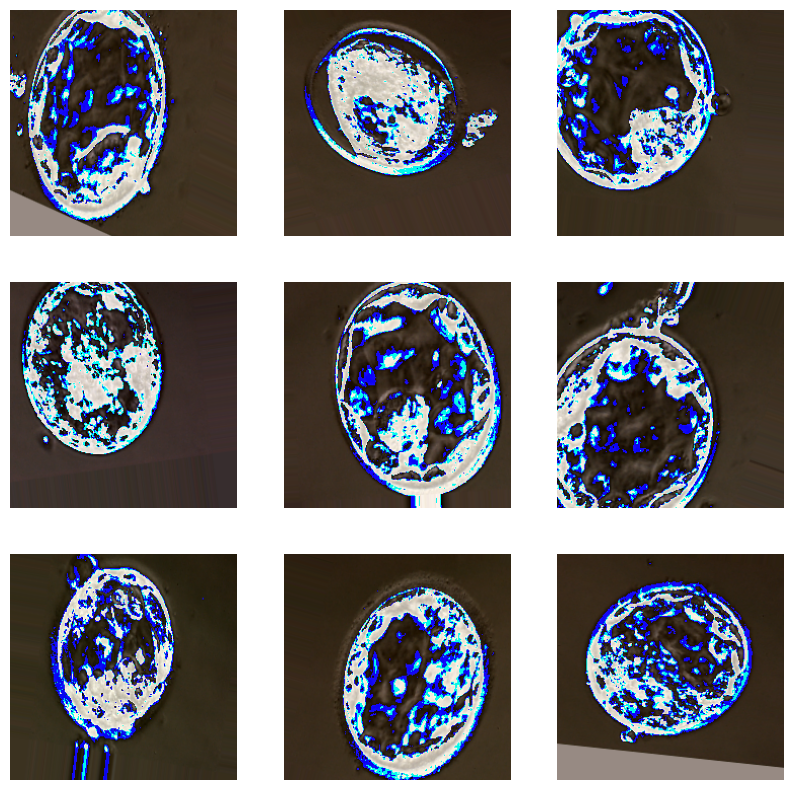

In [23]:
image_batch, label_batch = next(iter(dataset_treinamento))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(image_batch[i].astype("uint8"), cmap=plt.cm.binary) #cmap='gray', vmin=0, vmax=255
  # plt.title(class_names[label_batch[i]])
  label = label_batch[i]
  # plt.title(class_names[label])
  plt.axis("off")

plt.savefig("Exemplo_Data_Augmentation.pdf"); # salvar a figura em pdf

In [24]:
dataset_treinamento.class_indices

{'00R': 0, '01B': 1}

In [25]:
dataset_treinamento.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

Quantidade 0:  138
Quantidade 1:  432


<ipython-input-26-b6ec39a4e44d>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['0', '1'], y=[len(lista_zero), len(lista_um)], palette=['blue', 'green']);


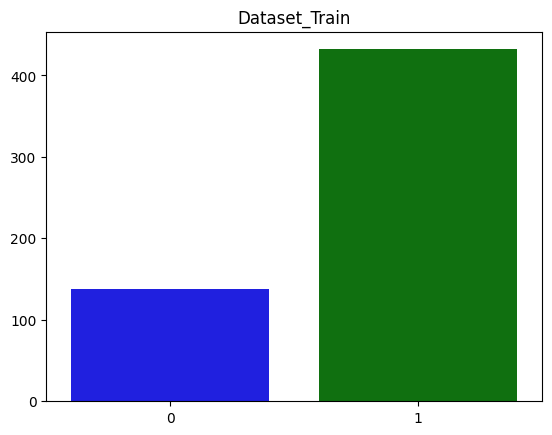

In [26]:
lista_zero = []
lista_um = []

for i in range(len(dataset_treinamento.classes)):
  if dataset_treinamento.classes[i] == 0:
    lista_zero.append(i)
  else:
    lista_um.append(i)

print(f'Quantidade 0: ', len(lista_zero))
print(f'Quantidade 1: ', len(lista_um))

# Conte a quantidade de ocorrências de cada valor nas listas
contagem_um = lista_um.count(1)
contagem_zero = lista_zero.count(0)

# Crie um gráfico de barras com os dados
sns.barplot(x=['0', '1'], y=[len(lista_zero), len(lista_um)], palette=['blue', 'green']);
plt.title("Dataset_Train")
# Exiba o gráfico
plt.show();

# Dataset Validação

In [27]:
gerador_validacao = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

dataset_validacao = gerador_validacao.flow_from_directory('/content/validation',
                                                              target_size=(224,224),
                                                              color_mode = 'rgb',
                                                              batch_size=16,
                                                              class_mode='categorical',
                                                              shuffle = False) # as imagens do dataset NÃO serão embaralhadas antes de cada época na validação. É um teste do modelo depois de cada época

Found 72 images belonging to 2 classes.


Quantidade 0:  18
Quantidade 1:  54


<ipython-input-31-1562eac6d8f2>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['0', '1'], y=[len(lista_zero), len(lista_um)], palette=['blue', 'green']);


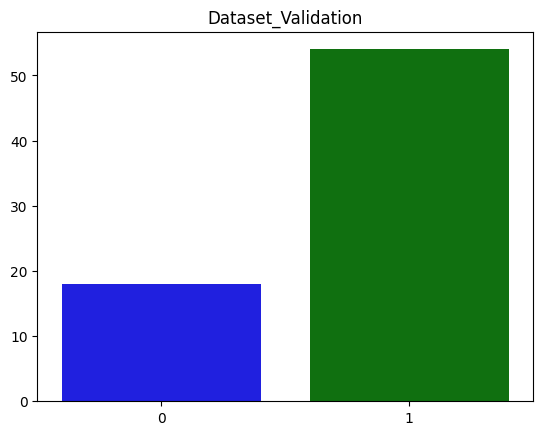

In [31]:
lista_zero = []
lista_um = []

for i in range(len(dataset_validacao.classes)):
  if dataset_validacao.classes[i] == 0:
    lista_zero.append(i)
  else:
    lista_um.append(i)

print(f'Quantidade 0: ', len(lista_zero))
print(f'Quantidade 1: ', len(lista_um))

# Conte a quantidade de ocorrências de cada valor nas listas
contagem_um = lista_um.count(1)
contagem_zero = lista_zero.count(0)

# Crie um gráfico de barras com os dados
sns.barplot(x=['0', '1'], y=[len(lista_zero), len(lista_um)], palette=['blue', 'green']);
plt.title("Dataset_Validation")
# Exiba o gráfico
plt.show();

# Dataset Teste

In [32]:
gerador_teste = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

dataset_teste = gerador_teste.flow_from_directory('/content/test',
                                                  target_size=(224,224),
                                                  color_mode = 'rgb',
                                                  batch_size=1,
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 71 images belonging to 2 classes.


Quantidade 0:  17
Quantidade 1:  54


<ipython-input-33-11d15bf6048e>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['0', '1'], y=[len(lista_zero), len(lista_um)], palette=['blue', 'green']);


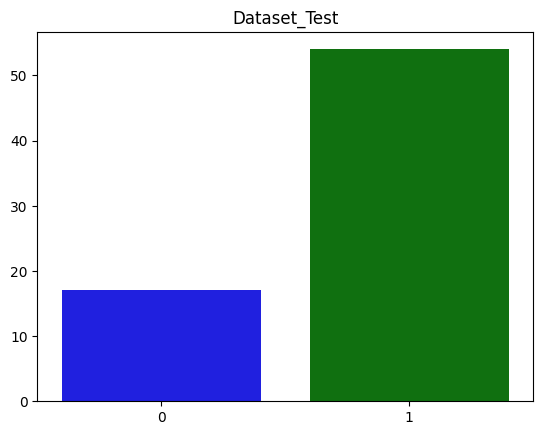

In [33]:
lista_zero = []
lista_um = []

for i in range(len(dataset_teste.classes)):
  if dataset_teste.classes[i] == 0:
    lista_zero.append(i)
  else:
    lista_um.append(i)

print(f'Quantidade 0: ', len(lista_zero))
print(f'Quantidade 1: ', len(lista_um))

# Conte a quantidade de ocorrências de cada valor nas listas
contagem_um = lista_um.count(1)
contagem_zero = lista_zero.count(0)

# Crie um gráfico de barras com os dados
sns.barplot(x=['0', '1'], y=[len(lista_zero), len(lista_um)], palette=['blue', 'green']);
plt.title("Dataset_Test")
# Exiba o gráfico
plt.show();

# Rede neural pré-treinada
- Documentação: https://keras.io/api/applications/
## ResNet50

In [34]:
modelo_base = tf.keras.applications.ResNet50(weights='imagenet', include_top=False)

## ResNet101

In [35]:
# # (T.2.14.7.1)
# modelo_base = tf.keras.applications.ResNet101(weights='imagenet', include_top=False)

## VGG19

In [ ]:
# # (T.3.14.7.1)
# modelo_base = tf.keras.applications.VGG19(weights='imagenet', include_top=False)

In [36]:
modelo_base.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, None, None, 3)  │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, None, None, 64) │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, None, None, 64) │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, None, None, 64) │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, None, None, 64) │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, None, None, 64) │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, None, None, 64) │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, None, None, 64) │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, None, None, 64) │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, None, None, 64) │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, None, None, 64) │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, None, None, 64) │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, None, None,     │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, None, None,     │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [37]:
len(modelo_base.layers)

175

In [38]:
for layer in modelo_base.layers:
  #print(layer)
  layer.trainable = False

In [39]:
for layer in modelo_base.layers:
  print(layer, layer.trainable)

<InputLayer name=input_layer_2, built=True> False
<ZeroPadding2D name=conv1_pad, built=True> False
<Conv2D name=conv1_conv, built=True> False
<BatchNormalization name=conv1_bn, built=True> False
<Activation name=conv1_relu, built=True> False
<ZeroPadding2D name=pool1_pad, built=True> False
<MaxPooling2D name=pool1_pool, built=True> False
<Conv2D name=conv2_block1_1_conv, built=True> False
<BatchNormalization name=conv2_block1_1_bn, built=True> False
<Activation name=conv2_block1_1_relu, built=True> False
<Conv2D name=conv2_block1_2_conv, built=True> False
<BatchNormalization name=conv2_block1_2_bn, built=True> False
<Activation name=conv2_block1_2_relu, built=True> False
<Conv2D name=conv2_block1_0_conv, built=True> False
<Conv2D name=conv2_block1_3_conv, built=True> False
<BatchNormalization name=conv2_block1_0_bn, built=True> False
<BatchNormalization name=conv2_block1_3_bn, built=True> False
<Add name=conv2_block1_add, built=True> False
<Activation name=conv2_block1_out, built=True>

# Camada densa personalizada

In [40]:
modelo_base.output

<KerasTensor shape=(None, None, None, 2048), dtype=float32, sparse=False, name=keras_tensor_359>

In [41]:
from functools import partial

RegularizadedDense = partial(keras.layers.Dense,
                             activation = "elu",
                             kernel_initializer = "he_normal",
                             kernel_regularizer = keras.regularizers.l2(0.001))

head_model = modelo_base.output
head_model = GlobalAveragePooling2D()(head_model)
head_model = RegularizadedDense(1029)(head_model)
head_model = RegularizadedDense(1029)(head_model)
head_model = RegularizadedDense(514)(head_model)
head_model = RegularizadedDense(257)(head_model)
head_model = RegularizadedDense(units=2, activation='softmax')(head_model) # Função de ativação = "softmax" para ver a probabilidade entre as duas classes

print('Feito!')

Feito!


# Construção e treinamento da rede neural

In [42]:
modelo_base.input

<KerasTensor shape=(None, None, None, 3), dtype=float32, sparse=None, name=keras_tensor_185>

In [43]:
network = Model(inputs = modelo_base.input, outputs = head_model)

In [44]:
for layer in network.layers:
  print(layer, layer.trainable)

<InputLayer name=input_layer_2, built=True> False
<ZeroPadding2D name=conv1_pad, built=True> False
<Conv2D name=conv1_conv, built=True> False
<BatchNormalization name=conv1_bn, built=True> False
<Activation name=conv1_relu, built=True> False
<ZeroPadding2D name=pool1_pad, built=True> False
<MaxPooling2D name=pool1_pool, built=True> False
<Conv2D name=conv2_block1_1_conv, built=True> False
<BatchNormalization name=conv2_block1_1_bn, built=True> False
<Activation name=conv2_block1_1_relu, built=True> False
<Conv2D name=conv2_block1_2_conv, built=True> False
<BatchNormalization name=conv2_block1_2_bn, built=True> False
<Activation name=conv2_block1_2_relu, built=True> False
<Conv2D name=conv2_block1_0_conv, built=True> False
<Conv2D name=conv2_block1_3_conv, built=True> False
<BatchNormalization name=conv2_block1_0_bn, built=True> False
<BatchNormalization name=conv2_block1_3_bn, built=True> False
<Add name=conv2_block1_add, built=True> False
<Activation name=conv2_block1_out, built=True>

In [45]:
network.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, None, None, 3)  │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, None, None, 64) │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, None, None, 64) │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, None, None, 64) │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, None, None, 64) │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, None, None, 64) │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, None, None, 64) │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, None, None, 64) │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, None, None, 64) │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, None, None, 64) │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, None, None, 64) │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, None, None, 64) │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, None, None,     │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, None, None,     │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 27,418,294 (104.59 MB)

 Trainable params: 3,830,582 (14.61 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

# Compilando o Modelo

In [46]:
network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1.5e-4) , loss='categorical_crossentropy', metrics=['accuracy'])

print("Feito")

Feito


In [98]:
history = network.fit(dataset_treinamento, epochs=100, validation_data=dataset_validacao)

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 224ms/step - accuracy: 0.9693 - loss: 1.2415 - val_accuracy: 0.9167 - val_loss: 1.3471
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 218ms/step - accuracy: 0.9888 - loss: 1.1919 - val_accuracy: 0.9306 - val_loss: 1.3119
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 217ms/step - accuracy: 0.9932 - loss: 1.1634 - val_accuracy: 0.9306 - val_loss: 1.3136
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 218ms/step - accuracy: 0.9963 - loss: 1.1519 - val_accuracy: 0.8750 - val_loss: 1.5041
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 219ms/step - accuracy: 0.9595 - loss: 1.2071 - val_accuracy: 0.9167 - val_loss: 1.3261
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 218ms/step - accuracy: 0.9652 - loss: 1.1680 - val_accuracy: 0.8472 - val_loss: 1.3827
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 214ms/step - accuracy: 0.9738 - loss: 1.1226 - val_accuracy: 0.9167 - val_loss: 1.3203
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 215ms/step - accuracy: 0.9877 - loss: 1.0896 - v

# Avaliação da rede neural

In [100]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [101]:
# Estabelecendo os parâmetros de treinamento para plotagem dos gráficos de desempenho

loss = np.array(history.history['loss'])
loss_val = np.array(history.history['val_loss'])

acc = np.array(history.history['accuracy'])
acc_val = np.array(history.history['val_accuracy'])

epochs = range(len(history.history['loss']))

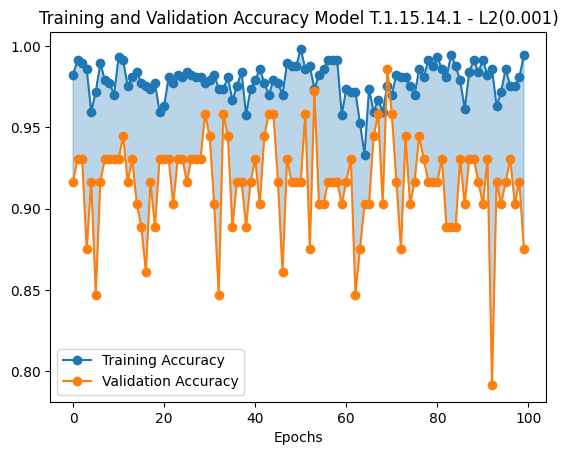

In [102]:
# Acurácia do Modelo

plt.figure()
plt.plot(acc, label='Training Accuracy', marker='o')
plt.plot(acc_val, label='Validation Accuracy', marker='o')
plt.fill_between(epochs, acc, acc_val, where=(acc > acc_val), color='C0', alpha=0.3, interpolate=True)
plt.fill_between(epochs, acc, acc_val, where=(acc < acc_val), color='C1', alpha=0.3, interpolate=True)
plt.xlabel('Epochs')
plt.title('Training and Validation Accuracy Model T.1.15.14.1 - L2(0.001)')
plt.legend()
plt.savefig("Training and Validation Accuracy Model T.1.15.14.1 - L2(0.001).pdf"); # salvar a figura em pdf


plt.show()

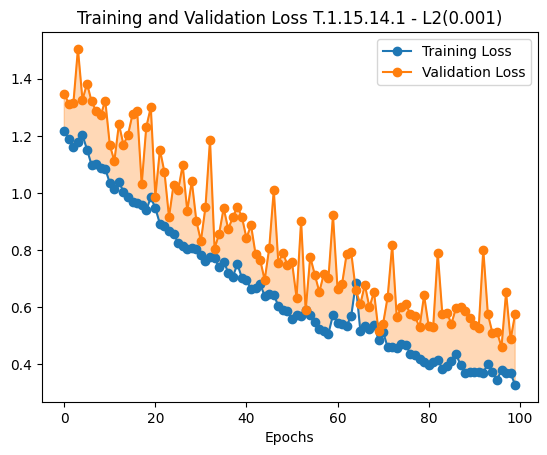

In [103]:
# Erro do Modelo

plt.figure()
plt.plot(loss, label='Training Loss', marker='o')
plt.plot(loss_val, label='Validation Loss', marker='o')
plt.fill_between(epochs, loss, loss_val, where=(loss > loss_val), color='C0', alpha=0.3, interpolate=True)
plt.fill_between(epochs, loss, loss_val, where=(loss < loss_val), color='C1', alpha=0.3, interpolate=True)
plt.xlabel('Epochs')
plt.title('Training and Validation Loss T.1.15.14.1 - L2(0.001)')
plt.legend()
plt.savefig("Training and Validation Loss T.1.15.14.1 - L2(0.001).pdf"); # salvar a figura em pdf

plt.show()

In [104]:
dataset_teste.class_indices

{'00R': 0, '01B': 1}

In [105]:
probabilidades = network.predict(dataset_teste)
probabilidades

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


array([[9.99959946e-01, 3.99995151e-05],
       [9.97548878e-01, 2.45110691e-03],
       [1.24757891e-04, 9.99875188e-01],
       [9.99850273e-01, 1.49758140e-04],
       [9.67444897e-01, 3.25551592e-02],
       [9.99194443e-01, 8.05556192e-04],
       [9.99998808e-01, 1.22562949e-06],
       [2.48741880e-02, 9.75125849e-01],
       [9.99861002e-01, 1.39007039e-04],
       [1.37071088e-01, 8.62928927e-01],
       [1.38406083e-01, 8.61593843e-01],
       [9.99836445e-01, 1.63573539e-04],
       [9.88795996e-01, 1.12040341e-02],
       [9.99988556e-01, 1.14550921e-05],
       [9.99938726e-01, 6.12628646e-05],
       [9.97854054e-01, 2.14592367e-03],
       [9.99991417e-01, 8.57330087e-06],
       [1.40197717e-05, 9.99985933e-01],
       [1.82576245e-04, 9.99817371e-01],
       [3.44936103e-02, 9.65506375e-01],
       [9.51587845e-06, 9.99990463e-01],
       [8.21518370e-07, 9.99999166e-01],
       [5.70928096e-04, 9.99429047e-01],
       [1.18062485e-06, 9.99998808e-01],
       [1.390556

In [106]:
# índice da coluna com maior probabilidade

previsoes = np.argmax(probabilidades, axis = 1) # - vetor com 0 ou 1

print("Previsões")
print(" ")
print(previsoes)

Previsões
 
[0 0 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1]


In [107]:
dataset_teste.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1], dtype=int32)

# Avaliação do Modelo

In [108]:
# Avaliação do modelo
model_evaluation = network.evaluate(dataset_teste)

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8647 - loss: 0.9657


# Matriz de Confusão

In [109]:
# Acurácia do Modelo

from sklearn.metrics import accuracy_score
accuracy_score(dataset_teste.classes, previsoes)

0.9295774647887324

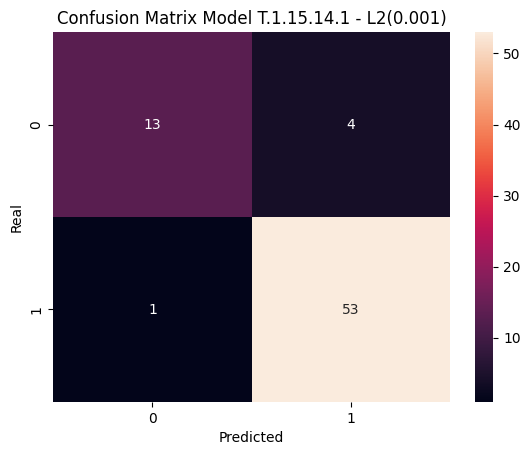

In [110]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(dataset_teste.classes, previsoes)

plt.figure()
plt.title('Confusion Matrix Model T.1.15.14.1 - L2(0.001)')

sns.heatmap(cm, annot=True)

plt.xlabel('Predicted')
plt.ylabel('Real')

plt.savefig("Confusion Matrix Model T.1.15.14.1 - L2(0.001).pdf"); # salvar a figura em pdf

plt.show()

In [111]:
from sklearn.metrics import classification_report
print(classification_report(dataset_teste.classes, previsoes))

              precision    recall  f1-score   support

           0       0.93      0.76      0.84        17
           1       0.93      0.98      0.95        54

    accuracy                           0.93        71
   macro avg       0.93      0.87      0.90        71
weighted avg       0.93      0.93      0.93        71



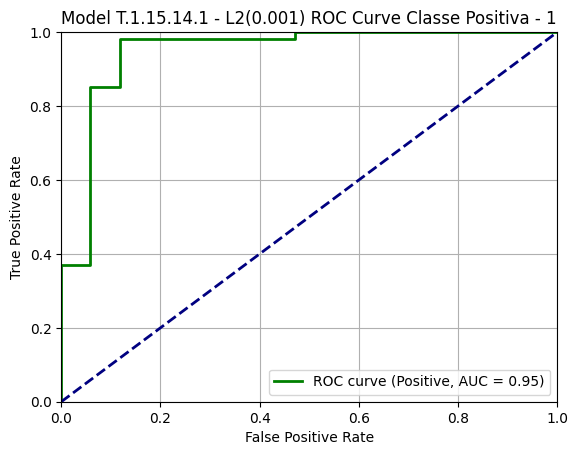

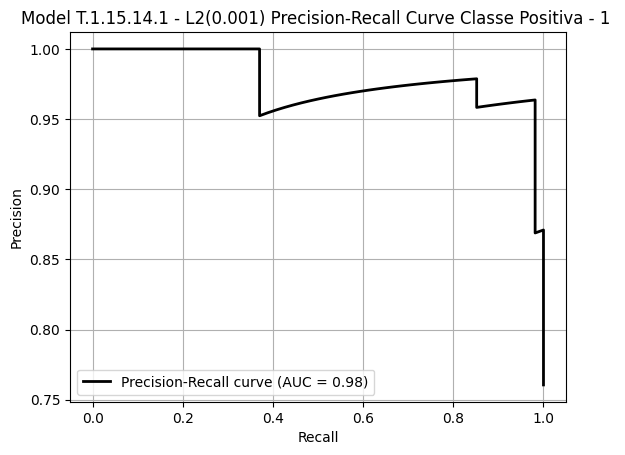

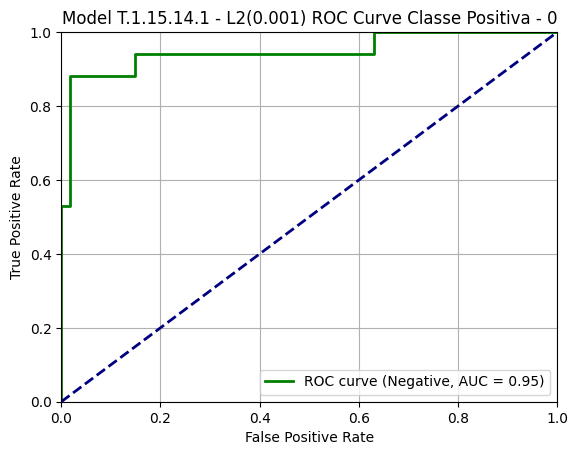

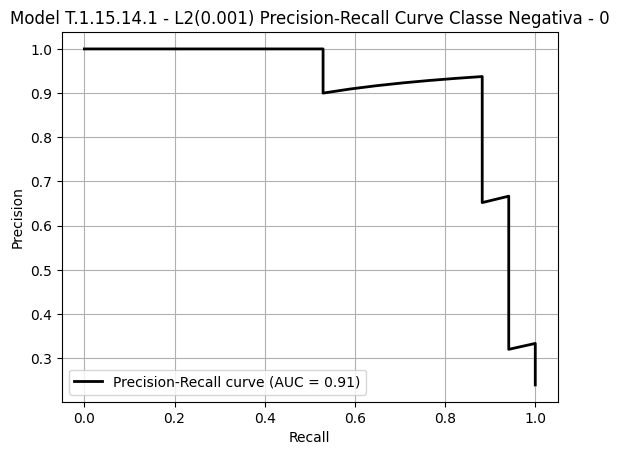

In [112]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Obter probabilidades previstas para ambas as classes
y_probas_positive = probabilidades[:, 1]  # Probabilidades para a classe positiva
y_probas_negative = probabilidades[:, 0]  # Probabilidades para a classe negativa

# Gerar e plotar a curva ROC para a classe positiva - 1
fpr_pos, tpr_pos, _ = roc_curve(dataset_teste.classes, y_probas_positive)
roc_auc_pos = auc(fpr_pos, tpr_pos)
plt.figure()
plt.plot(fpr_pos, tpr_pos, color='green', lw=2, label=f'ROC curve (Positive, AUC = {roc_auc_pos:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model T.1.15.14.1 - L2(0.001) ROC Curve Classe Positiva - 1')
plt.legend(loc="lower right")
plt.savefig("Model T.1.15.14.1 - L2(0.001) ROC Curve Classe Positiva - 1.pdf"); # salvar a figura em png
plt.show()

# Gerar e plotar a curva Precision-Recall para a classe positiva - 1
precision_pos, recall_pos, _ = precision_recall_curve(dataset_teste.classes, y_probas_positive)
pr_auc_pos = auc(recall_pos, precision_pos)
plt.figure()
plt.plot(recall_pos, precision_pos, color='black', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc_pos:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.title('Model T.1.15.14.1 - L2(0.001) Precision-Recall Curve Classe Positiva - 1 ')
plt.legend(loc="lower left")
plt.savefig("Model T.1.15.14.1 - L2(0.001) Precision-Recall Curve Classe Positiva - 1.pdf"); # salvar a figura em png
plt.show()

# Gerar e plotar a curva ROC para a classe negativa - 0
fpr_neg, tpr_neg, _ = roc_curve(1 - dataset_teste.classes, y_probas_negative)
roc_auc_neg = auc(fpr_neg, tpr_neg)
plt.figure()
plt.plot(fpr_neg, tpr_neg, color='green', lw=2, label=f'ROC curve (Negative, AUC = {roc_auc_neg:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model T.1.15.14.1 - L2(0.001) ROC Curve Classe Positiva - 0')
plt.legend(loc="lower right")
plt.savefig("Model T.1.15.14.1 - L2(0.001) ROC Curve Classe Negativa - 0.pdf"); # salvar a figura em pdf
plt.show()

# Gerar e plotar a curva Precision-Recall para a classe negativa - 0
precision_neg, recall_neg, _ = precision_recall_curve(1 - dataset_teste.classes, y_probas_negative)
pr_auc_neg = auc(recall_neg, precision_neg)
plt.figure()
plt.plot(recall_neg, precision_neg, color='black', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc_neg:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.title('Model T.1.15.14.1 - L2(0.001) Precision-Recall Curve Classe Negativa - 0')
plt.legend(loc="lower left")
plt.savefig("Model T.1.15.14.1 - L2(0.001) Precision-Recall Curve Classe Negativa - 0.pdf"); # salvar a figura em pdf
plt.show()

# Salvar a rede neural

In [113]:
model_json = network.to_json()
with open('T.1.15.14.1.json','w') as json_file:
  json_file.write(model_json)


In [114]:
from keras.models import save_model
network_saved = save_model(network, '/content/weights_T.1.15.14.1.hdf5')

# Carregar a rede neural

In [115]:
with open('T.1.15.14.1.json', 'r') as json_file:
  json_saved_model = json_file.read()
json_saved_model

'{"module": "keras.src.models.functional", "class_name": "Functional", "config": {"name": "functional_3", "trainable": true, "layers": [{"module": "keras.layers", "class_name": "InputLayer", "config": {"batch_shape": [null, null, null, 3], "dtype": "float32", "sparse": false, "name": "input_layer_2"}, "registered_name": null, "name": "input_layer_2", "inbound_nodes": []}, {"module": "keras.layers", "class_name": "ZeroPadding2D", "config": {"name": "conv1_pad", "trainable": false, "dtype": {"module": "keras", "class_name": "DTypePolicy", "config": {"name": "float32"}, "registered_name": null}, "padding": [[3, 3], [3, 3]], "data_format": "channels_last"}, "registered_name": null, "build_config": {"input_shape": [null, null, null, 3]}, "name": "conv1_pad", "inbound_nodes": [{"args": [{"class_name": "__keras_tensor__", "config": {"shape": [null, null, null, 3], "dtype": "float32", "keras_history": ["input_layer_2", 0, 0]}}], "kwargs": {}}]}, {"module": "keras.layers", "class_name": "Conv2D

In [116]:
network_loaded = tf.keras.models.model_from_json(json_saved_model)
network_loaded.load_weights('weights_T.1.15.14.1.hdf5')
network_loaded.compile(loss = 'categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1.5e-4) , metrics=['accuracy'])

In [117]:
network_loaded.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, None, None, 3)  │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, None, None, 64) │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, None, None, 64) │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, None, None, 64) │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, None, None, 64) │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, None, None, 64) │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, None, None, 64) │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, None, None, 64) │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, None, None, 64) │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, None, None, 64) │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, None, None, 64) │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, None, None, 64) │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, None, None,     │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, None, None,     │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 27,418,294 (104.59 MB)

 Trainable params: 3,830,582 (14.61 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Imagem 3AA.PNG
12.94% Ruim e 87.06% Bom.


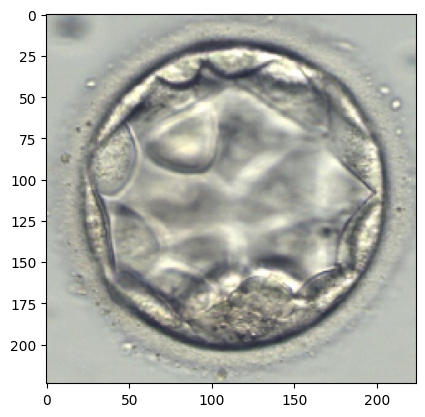

In [118]:
image_test_1 = tf.keras.preprocessing.image.load_img(r'/content/3AA 1 EXTRA.PNG', target_size=(224,224))
plt.imshow(image_test_1);

image_test_1 = tf.keras.preprocessing.image.img_to_array(image_test_1)
image_test_1 = np.expand_dims(image_test_1, axis = 0)
image_test_1 = tf.keras.applications.resnet50.preprocess_input(image_test_1)

predictions1 = network_loaded.predict(image_test_1)

score = float(predictions1[0][0])

print("Imagem 3AA.PNG")
print(f"{100 * score:.2f}% Ruim e {100 * (1-score):.2f}% Bom.")